In [218]:
import pandas as pd
import numpy as np

In [219]:
btc = pd.read_excel('../data/pricing_data.xlsx', sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

In [220]:
# Calculate price changes
btc['PriceChange'] = btc['Close'].diff()

# Calculate percentage changes
btc['PctChange'] = btc['Close'].pct_change()

# Cap percentage changes at ±3%
btc['CappedPctChange'] = btc['PctChange'].clip(lower=-0.03, upper=0.03)

# Calculate capped price changes
btc['CappedPriceChange'] = btc['CappedPctChange'] * btc['Close'].shift(1)

# Separate gains and losses
btc['Gain'] = btc['CappedPriceChange'].where(btc['CappedPriceChange'] > 0, 0)
btc['Loss'] = -btc['CappedPriceChange'].where(btc['CappedPriceChange'] < 0, 0)

# Calculate average gains and losses (using a 26-period window)
window = 13
btc['AvgGain'] = btc['Gain'].rolling(window=window, min_periods=1).mean()
btc['AvgLoss'] = btc['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
btc['RS'] = btc['AvgGain'] / btc['AvgLoss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

# Set first few RSI values to NaN due to instability
btc.loc[btc.index[:window-1], 'RSI'] = np.nan


In [221]:
btc['MA200'] = btc['Close'].rolling(window=200).mean()
btc['MA20'] = btc['Close'].rolling(window=20).mean()
btc['MA50'] = btc['Close'].rolling(window=50).mean()

In [222]:
k_period = 12
d_period = 3
btc['HighestHigh'] = btc['High'].rolling(window=k_period).max()
btc['LowestLow'] = btc['Low'].rolling(window=k_period).min()

# Calculate %K
btc['%K'] = 100 * (btc['Close'] - btc['LowestLow']) / (btc['HighestHigh'] - btc['LowestLow'])

# Calculate %D (the moving average of %K)
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

In [223]:

btc['EMA_6'] = btc['Close'].rolling(window=12).mean() # 6-period EMA
btc['EMA_12'] = btc['Close'].rolling(window=26).mean() # 12-period EMA

# Calculate the MACD line
btc['MACD'] = btc['EMA_6'] - btc['EMA_12']

btc['Signal'] = btc['MACD'].ewm(span=9, adjust=False).mean()

In [224]:
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
btc['STD15'] = btc['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
btc['BB_Upper'] = btc['SMAVG (15)  on Close'] + (btc['STD15'] * 2)
btc['BB_Lower'] = btc['SMAVG (15)  on Close'] - (btc['STD15'] * 2)

# Calculate Bollinger Band Width
btc['BB_Width'] = (btc['BB_Upper'] - btc['BB_Lower']) / btc['SMAVG (15)  on Close']

# Calculate the Percent B
# spy['Percent_B'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower'])

# Calculate Bollinger Band Squeeze
# spy['BB_Squeeze'] = spy['BB_Width'].rolling(window=15).mean()

In [225]:
# Create lagged columns (shift by 1)
lagged_btc = btc.copy()
for col in btc.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_btc[col + '_lag1'] = btc[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_btc = lagged_btc[['Date', 'Close', 'Open'] + [col + '_lag1' for col in btc.columns if col not in ['Date', 'Close']]]

lagged_btc.drop(index=lagged_btc.index[:30], inplace=True)

# Display result
lagged_btc.head()

,Date,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,SMAVG (15) on Close_lag1,PriceChange_lag1,...,%K_lag1,%D_lag1,EMA_6_lag1,EMA_12_lag1,MACD_lag1,Signal_lag1,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1
30,2024-01-01 15:00:00,42488.50,42401.07,42319.73,42425.06,42309.16,42328.36,42381.63,42403.86,81.34,...,37.448507,22.399840,42408.357500,42453.842692,-45.485192,-59.692875,137.085569,42678.031139,42129.688861,0.012931
31,2024-01-01 15:30:00,42490.34,42488.50,42401.07,42495.70,42401.07,42348.20,42376.89,42417.77,87.43,...,53.384857,37.818526,42408.727500,42448.977308,-40.249808,-55.804261,136.294097,42690.358194,42145.181806,0.012853
32,2024-01-01 16:00:00,42483.53,42490.34,42488.50,42500.88,42441.13,42386.88,42368.57,42422.96,1.84,...,68.879125,53.237496,42399.596667,42443.141538,-43.544872,-53.352383,134.507948,42691.975896,42153.944104,0.012683
33,2024-01-01 16:30:00,42550.10,42483.53,42490.34,42534.45,42461.38,42436.63,42373.88,42424.18,-6.81,...,71.551767,64.605250,42395.234167,42436.596154,-41.361987,-50.954304,134.382552,42692.945103,42155.414897,0.012670
34,2024-01-01 17:00:00,42590.30,42550.10,42483.53,42552.55,42463.72,42482.71,42395.88,42428.58,66.57,...,91.739130,77.390007,42393.275833,42434.720000,-41.444167,-49.052277,132.914844,42694.409688,42162.750312,0.012531


In [226]:
lagged_btc = lagged_btc[(lagged_btc['Date'] >= '2025-01-01') & (lagged_btc['Date'] < '2025-03-01')]

In [227]:
btc = pd.read_csv("../data/btc_rf_predictions_rolling.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = btc.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'BTC_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_btc = btc.rename(columns=rename_dict)

df_btc["Date"] = pd.to_datetime(df_btc["Date"])
df_btc

,Unnamed: 0,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,BTC_BreakHigh2_lag1
0,17539,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,False
1,17540,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,False
2,17541,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,False
3,17542,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,False
4,17543,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,False
...,...,...,...,...,...,...
2827,20366,2025-02-28 21:30:00,81465.09,82093.36098,80695.28,True
2828,20367,2025-02-28 22:00:00,81785.98,82832.43628,81465.09,True
2829,20368,2025-02-28 22:30:00,82054.27,82792.20484,81785.98,True
2830,20369,2025-02-28 23:00:00,84317.02,83402.23912,82054.27,True


In [228]:
merged = df_btc.merge(lagged_btc, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'BTC_BreakHigh2_lag1'])

In [229]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
commission_rate = 0.0005
trading_results2 = merged.copy().reset_index(drop=True)

# Calculate price change predictions
trading_results2['Predicted_Diff'] = trading_results2['BTC_Predicted'] / trading_results2['Open'] - 1

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'BTC_Actual']
    current_open = trading_results2.at[i, 'Open']
    prev_ma200 = trading_results2.at[i-1, 'MA200_lag1']
    prev_ma20 = trading_results2.at[i-1, 'MA20_lag1']
    prev_ma50 = trading_results2.at[i-1, 'MA50_lag1']
    lowerbb = trading_results2.at[i, 'BB_Lower_lag1']
    upperbb = trading_results2.at[i, 'BB_Upper_lag1']
    prev_rsi = trading_results2.at[i, 'RSI_lag1']

    if trading_results2.at[i, 'Predicted_Diff'] > 0.003 and current_open <= lowerbb and prev_ma50 > prev_ma200: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted_Diff'] < -0.0015 and current_open >= upperbb and prev_ma50 < prev_ma200:
        trading_results2.at[i, 'Signal'] = -1

    current_price = trading_results2['BTC_Actual'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]

    # Trading logic
    if current_signal == 1 and cash > 16000:  # Buy
        buy_amount = cash-16000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal == -1 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_77298/1191308935.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.009045509029895' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_77298/1191308935.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '91585.78' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Entry_Price'] = entry_price
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_77298/1191308935.py:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '199907.99999999997' has dtype incompatible with int64, plea

Total Return: 15.84%
Number of Trades: 4
Maximum Drawdown: 7.05%
Final Portfolio Value: 231,686.97


In [204]:
trading_results2[trading_results2['Signal'] != 0]

,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
46,2025-01-01 23:00:00,93969.42,93727.13776,93976.59,93976.59,93718.59,94019.59,93515.91,93741.21,93533.73,...,93960.815776,92907.244224,0.011276,-0.002654,-1,0.000000,200000.000000,0.00,200000.000000,Hold
484,2025-01-11 02:00:00,94993.12,95620.24292,95775.25,95773.92,94341.72,95799.47,94058.72,94182.21,94097.27,...,95665.938728,93122.581272,0.026944,-0.001605,-1,0.000000,200000.000000,0.00,200000.000000,Hold
613,2025-01-13 18:30:00,91585.78,92288.85778,91925.38,91924.50,92802.03,92819.28,91864.91,92725.09,93255.20,...,95164.795075,92098.704925,0.032746,0.003964,1,2.009046,15908.000000,91585.78,199908.000000,Buy
614,2025-01-13 19:00:00,91369.52,92037.20638,91585.78,91583.50,91924.50,91929.27,91315.80,92412.12,93001.54,...,95219.822301,91685.197699,0.037823,0.004954,1,2.009046,15908.000000,91585.78,199473.523818,Hold
766,2025-01-16 23:00:00,98361.75,97901.51202,97572.94,97572.94,99324.62,99337.69,97468.44,98834.53,99006.98,...,100086.721527,98094.798473,0.020102,0.003367,1,2.009046,15908.000000,91585.78,213521.232098,Hold
927,2025-01-20 07:30:00,101206.47,100962.48236,100393.83,100400.69,103326.50,103326.50,100257.53,103132.38,104369.82,...,106547.764391,102508.515609,0.038643,0.005596,1,2.009046,15908.000000,91585.78,219236.404038,Hold
1102,2025-01-23 23:00:00,104232.64,104392.55140,105166.94,105166.94,102382.22,106024.97,102319.31,102620.04,102224.73,...,103705.142386,100730.877614,0.029097,-0.007363,-1,0.000000,225211.413228,0.00,225211.413228,Sell
1104,2025-01-24 00:00:00,106007.38,104897.13666,105260.19,105259.44,104229.14,105423.94,104224.25,103903.59,102818.28,...,104401.772482,100636.907518,0.036723,-0.003442,-1,0.000000,225211.413228,0.00,225211.413228,Hold
1105,2025-01-24 00:30:00,105168.50,105707.04602,106007.38,106007.38,105259.44,106850.25,105114.94,104610.08,103218.01,...,105028.449546,100520.590454,0.043862,-0.002833,-1,0.000000,225211.413228,0.00,225211.413228,Hold
1400,2025-01-30 04:00:00,104396.22,102727.57906,103585.25,103583.50,101509.95,103935.00,101460.02,102578.56,102312.84,...,103023.002372,101396.817628,0.015910,-0.008263,-1,0.000000,225211.413228,0.00,225211.413228,Hold


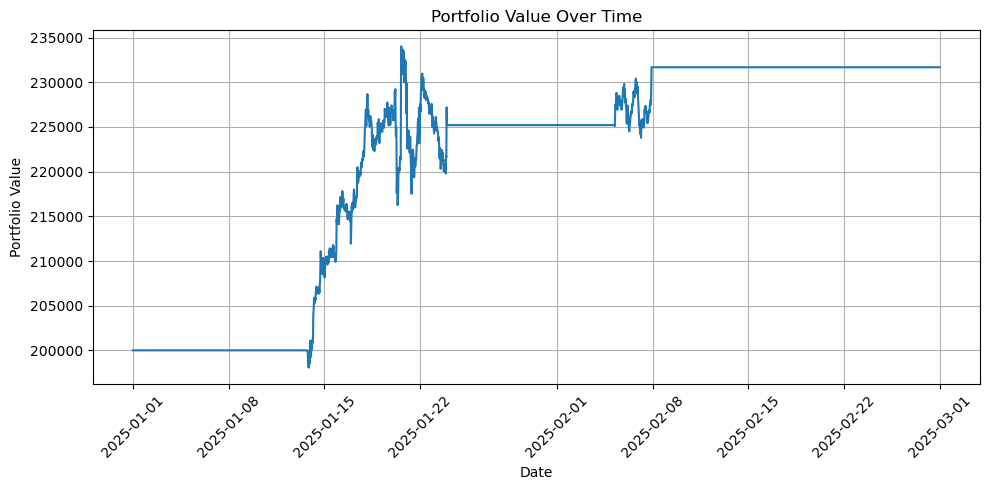

In [205]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results2['Date'], trading_results2['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

### SPY Strategy

In [24]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

spy['MA200'] = spy['Close'].rolling(window=200).mean()
spy['MA20'] = spy['Close'].rolling(window=20).mean()
spy['MA50'] = spy['Close'].rolling(window=50).mean()

k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()


spy['EMA_6'] = spy['Close'].rolling(window=12).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].rolling(window=26).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

spy['Signal'] = spy['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['MA20'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['MA20'] - (spy['STD15'] * 2)

# Calculate Bollinger Band Width
spy['BB_Width'] = (spy['BB_Upper'] - spy['BB_Lower']) / spy['SMAVG (15)  on Close']

# Calculate the Percent B
# spy['Percent_B'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower'])

# Calculate Bollinger Band Squeeze
# spy['BB_Squeeze'] = spy['BB_Width'].rolling(window=15).mean()

# Create lagged columns (shift by 1)
lagged_spy = spy.copy()
for col in spy.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_spy[col + '_lag1'] = spy[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_spy = lagged_spy[['Date', 'Close', 'Open'] + [col + '_lag1' for col in spy.columns if col not in ['Date', 'Close']]]

lagged_spy.drop(index=lagged_spy.index[:30], inplace=True)

# Display result
lagged_spy.head()

lagged_spy = lagged_spy[(lagged_spy['Date'] >= '2025-01-01') & (lagged_spy['Date'] < '2025-03-01')]

spy = pd.read_csv("../data/spy_rf_predictions_rolling.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])

merged = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'SPY_BreakHigh2_lag1'])

In [26]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results3['SPY_Actual'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100

# Calculate price change predictions
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted'] / trading_results3['Open'] - 1

# Create trading signals
trading_results3['Signal'] = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'
trading_results3['Vol_Mean'] = trading_results3['Volume_lag1'].rolling(20).mean()

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_open = trading_results3['Open'].iloc[i]
    prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]
    vol_mean = trading_results3['Vol_Mean'].iloc[i]

    # Generate trading signals
    if trading_results3.at[i, 'Predicted_Diff'] > 0 and current_open <= lowerbb: 
        trading_results3.at[i, 'Signal'] = 1  # Buy signal
    elif trading_results3.at[i, 'Predicted_Diff'] < 0 and current_open >= upperbb and trading_results3['Volume_lag1'].iloc[i] > vol_mean:
        trading_results3.at[i, 'Signal'] = -1  # Sell signal

    current_signal = trading_results3['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal == 1 and cash > current_price:  # Buy signal
        max_buy_units = int(cash / (current_price * (1 + commission_rate)))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results3.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 8.99%
Buy-and-Hold Return: 0.33%
Number of Trades: 9
Maximum Drawdown: 0.97%
Final Portfolio Value: 871,898.29
Final Cash: 355.89
Final Position: 1480
Total Commission Paid: 2,259.46


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_77298/473316827.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '71.05328800005373' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_77298/473316827.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799760.093288' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = portfolio_value


In [27]:
trading_results3

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,Cash,Portfolio_Value,Trade_Action,Vol_Mean
0,2025-01-01 00:00:00,586.900,588.502670,588.730,588.78,589.56,590.06,588.570,589.223,590.010,...,596.992870,583.264630,0.023295,-0.000471,0,0,800000.000000,800000.000000,Hold,NaN
1,2025-01-01 00:30:00,587.060,586.968758,586.900,586.88,588.78,588.80,586.820,588.662,589.595,...,595.744104,583.804396,0.020256,0.000151,0,0,800000.000000,800000.000000,Hold,NaN
2,2025-01-01 01:00:00,585.860,587.495580,587.060,587.04,586.88,587.84,586.540,588.422,589.242,...,595.071161,583.658339,0.019362,0.000776,0,0,800000.000000,800000.000000,Hold,NaN
3,2025-01-01 01:30:00,587.205,585.988060,585.860,585.86,587.04,587.40,585.740,587.632,588.716,...,594.867382,583.096118,0.019975,0.000219,0,0,800000.000000,800000.000000,Hold,NaN
4,2025-01-01 02:00:00,584.960,586.748484,587.205,587.12,585.86,587.31,584.900,587.151,588.405,...,594.440660,582.742340,0.019856,-0.000633,0,0,800000.000000,800000.000000,Hold,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2025-02-28 04:00:00,586.680,588.014102,589.185,589.18,590.73,590.78,588.340,592.339,593.115,...,598.556283,589.045317,0.016034,-0.001979,0,0,866608.085159,866608.085159,Hold,2247433.60
503,2025-02-28 04:30:00,585.130,587.134674,586.680,586.62,589.18,589.35,586.240,590.991,592.242,...,598.783167,587.679333,0.018734,0.000877,1,1480,355.887439,866348.287439,Buy,2437814.80
504,2025-02-28 22:30:00,585.835,586.081226,585.130,585.56,586.62,587.57,584.650,589.099,591.414,...,599.037859,586.072641,0.021893,0.000890,1,1480,355.887439,867391.687439,Hold,2960406.25
505,2025-02-28 23:00:00,588.250,586.202982,585.835,585.85,585.56,586.33,583.270,587.508,590.581,...,599.201838,584.941162,0.024101,0.000603,0,1480,355.887439,870965.887439,Hold,3187313.25


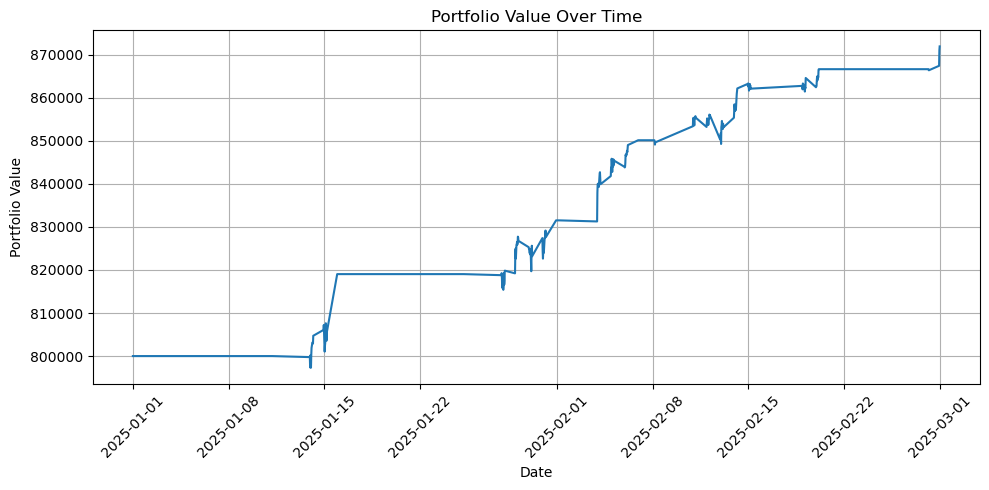

In [231]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results3['Date'], trading_results3['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()